In [2]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/j7zymbjelxlf4v5meujq32s27bbirf')
labels=['Positive', 'Neutral', 'Negative', 'Highly positive', 'Highly negative']
percent=1
sentiment_counts=df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best'].value_counts()
for i in range(len(labels)):
  df[df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']==labels[i]]=df[df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']==labels[i]].nlargest(int(percent*min(sentiment_counts)),'which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence')
labels=['Highly positive', 'Positive', 'Neutral', 'Negative', 'Highly negative'][::-1]
df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best'].value_counts()


Positive           283
Highly positive    283
Negative           283
Highly negative    283
Neutral            283
Name: which_of_these_sentiment_scores_does_the_above_image_fit_into_best, dtype: int64

In [3]:
import os
data_dir='/content/images'
os.mkdir(data_dir)
directories=['train','val']
for directory in directories:
  os.mkdir('/content/images/'+directory)
  for j, label in enumerate(labels):
    os.mkdir('/content/images/'+directory+'/'+str(j))

In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=774b925ed20d62c79dd275c88f47e16c9b835233c5646daae25085517f5a8171
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [5]:
import threading
import wget

def download_img(url,directory,label,i):
  try:
    wget.download(url, '/content/images/'+directory+'/'+label+'/img'+i+'.jpg', )
  except:
    pass
for i, label in enumerate(labels):
  urls = df[df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']==label]['imageurl']
  n_split=int(len(urls)*0.85)
  n=0
  for j, url in enumerate(urls):
    if n<n_split:
      directory=directories[0]
    else:
      directory=directories[1]
    threading.Thread(target=download_img, args= (url,directory,str(i),str(j),)).start()
    n+=1

In [6]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

images-size: torch.Size([16, 3, 224, 224])
out-size: torch.Size([3, 228, 1132])


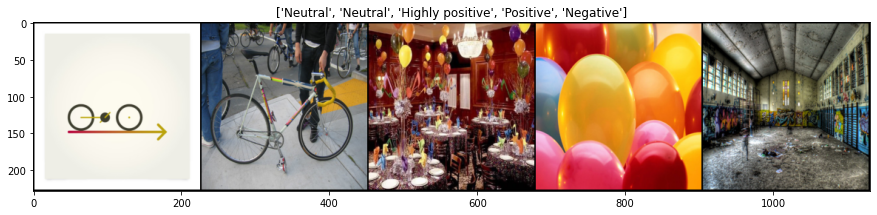

In [7]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt


def imshow(inp, title=None):
    figure = plt.figure(figsize=(15, 15))
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, classes = next(iter(dataloaders['val']))
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images[:5])
print("out-size:", out.shape)

imshow(out, title=[labels[x] for x in classes[:5]])

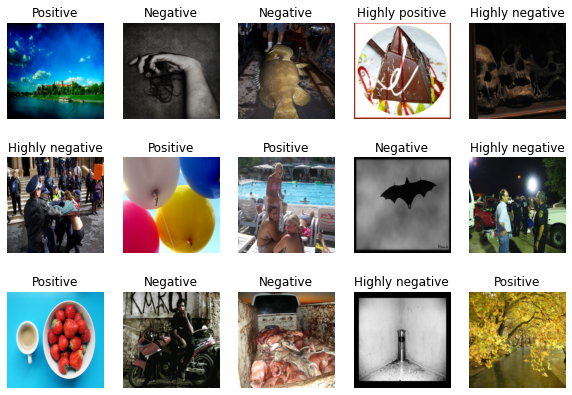

In [8]:
to_pil = transforms.ToPILImage()
images, classes = next(iter(dataloaders['val']))
images, classes = images, classes
fig=plt.figure(figsize=(10,7))
cols, rows= 5, int(len(images)/5)
for i in range(1, cols * rows + 1):
    image = to_pil(images[i])
    sub = fig.add_subplot(rows, cols, i)
    sub.set_title(labels[classes[i].item()] )
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [43]:
model = torchvision.models.resnet18(pretrained=True)
for p in model.parameters():
    p.requires_grad = False

out_dim = 5
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, int(model.fc.in_features/2)),
    torch.nn.Tanh(),
    torch.nn.Linear(int(model.fc.in_features/2), int(model.fc.in_features/4)),
    torch.nn.Tanh(),
    torch.nn.Linear(int(model.fc.in_features/4), out_dim)
    )
model.load_state_dict(model.state_dict())
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

In [50]:
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
X_valid, Y_valid = iter(dataloaders['val']).next()
X_valid, Y_valid = X_valid.to(device), Y_valid.to(device)
def train_model( scores, EPOCHS = 10, LEARNING_RATE = 0.05, WEIGHT_DECAY = 0.001):
  pbar = tqdm(total=EPOCHS*len(dataloaders['train']))
  optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
  itr=0
  best_loss=2
  best_weights=0
  for epoch in range(EPOCHS):
    for batch_id, (X_train_batch, Y_train_batch) in enumerate(dataloaders['train']):
      model.train()
      X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)
      Xtr = X_train_batch
      Y_pred = model(Xtr)
      loss = criterion(Y_pred,Y_train_batch)
      Y_pred = torch.argmax(Y_pred, 1)
      f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')
      acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      pbar.update()
      model.eval()
      Xvl = X_valid
      Y_pred = model(Xvl)  
      val_loss = criterion(Y_pred,Y_valid)
      Y_pred = torch.argmax(Y_pred, 1)
      val_f1 = f1_score(Y_valid.cpu(), Y_pred.cpu(), average='macro')
      val_acc = sum(Y_valid == Y_pred)/len(Y_pred)
      if (val_loss<best_loss):
        best_loss=val_loss
        best_weights=model.state_dict().copy()
        torch.save(model.state_dict(), '/content/best_weights.pht')
      if itr%int(len(dataloaders['train'])/3)==0:
        scores['train_loss']+=[loss]
        scores['train_f1']+=[f1]
        scores['train_acc']+=[acc]
        scores['val_loss']+=[val_loss]
        scores['val_f1']+=[val_f1]
        scores['val_acc']+=[val_acc]
        print('Epoch {}:{}'.format(epoch,batch_id))
        print( 'Train Evaluation loss: {}. f1:{} acc: {} '.format(loss, f1, acc) )
        print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(val_loss, val_f1, val_acc) )
      itr+=1
  torch.save(best_weights, '/content/drive/MyDrive/Colab Notebooks/best.pth')
  pbar.close()

In [156]:
from sklearn.metrics import confusion_matrix
import numpy as np

def eval_model(classes=5):
  X_true, Y_true = iter(dataloaders['val']).next()
  model.eval()
  X_true, Y_true = X_true.to(device), Y_true.to(device)
  Xvl = X_true
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_true)

  Y_pred = torch.argmax(Y_pred, 1)
  f1 = f1_score(Y_true.cpu(), Y_pred.cpu(), average='macro')

  acc = sum(Y_true == Y_pred)/len(Y_pred)

  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true.cpu(), Y_pred.cpu())
  lclasses = labels
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()
  print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

In [44]:
scores={'train_loss':[],'train_f1':[],'train_acc':[],'val_loss':[],'val_f1':[],'val_acc':[]}

In [51]:
train_model(scores, EPOCHS=100,LEARNING_RATE = 1e-3,WEIGHT_DECAY = 1e-8)

  0%|          | 0/5800 [00:00<?, ?it/s]

Epoch 0:0
Train Evaluation loss: 0.6659594774246216. f1:0.8031746031746032 acc: 0.8125 
Valid Evaluation loss: 1.1526429653167725. f1:0.5276190476190477 acc: 0.625 
Epoch 0:19
Train Evaluation loss: 0.6078473329544067. f1:0.7418181818181819 acc: 0.875 
Valid Evaluation loss: 1.2145838737487793. f1:0.48337662337662335 acc: 0.5625 
Epoch 0:38
Train Evaluation loss: 0.9955270290374756. f1:0.35333333333333333 acc: 0.5 
Valid Evaluation loss: 1.1586464643478394. f1:0.48337662337662335 acc: 0.5625 
Epoch 0:57
Train Evaluation loss: 0.5620877742767334. f1:0.8541666666666666 acc: 0.8333333730697632 
Valid Evaluation loss: 1.1735295057296753. f1:0.48337662337662335 acc: 0.5625 
Epoch 1:18
Train Evaluation loss: 0.7488803267478943. f1:0.691468253968254 acc: 0.6875 
Valid Evaluation loss: 1.2114747762680054. f1:0.5276190476190477 acc: 0.625 
Epoch 1:37
Train Evaluation loss: 0.67701256275177. f1:0.8375 acc: 0.8125 
Valid Evaluation loss: 1.1994274854660034. f1:0.5276190476190477 acc: 0.625 
Epoch

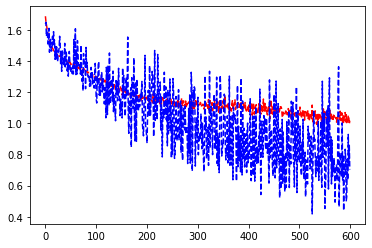

In [161]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

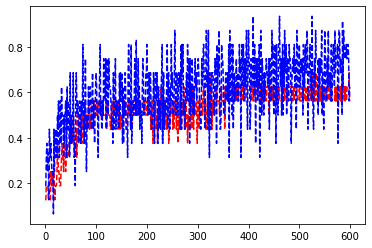

In [162]:
plt.plot(scores['val_acc'], '--', c='r')
plt.plot(scores['train_acc'], '--', c='b')

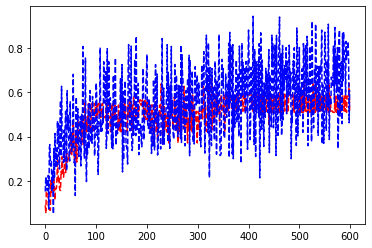

In [163]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

In [53]:
torch.save(model.state_dict(), '/content/drive/MyDrive/last_weights.pth')

In [152]:
model.load_state_dict(torch.load('/content/drive/MyDrive/best_weights.pth'))

<All keys matched successfully>

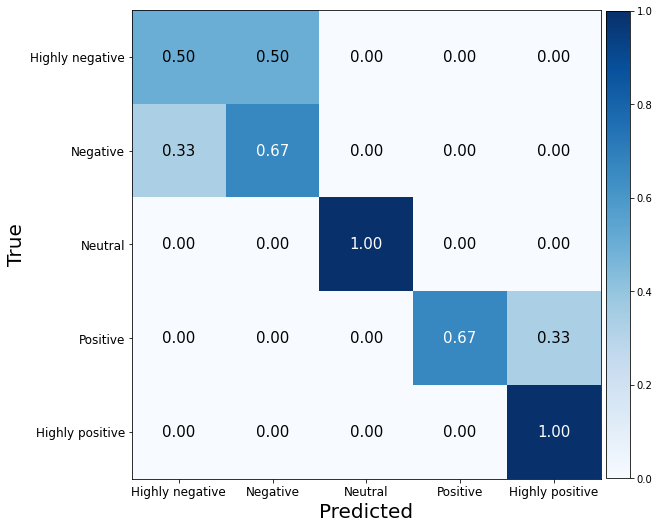

Loss:0.72, F1:0.75, Acc:0.75


In [160]:
eval_model()

#Antiguas pruebas

##lr$=1e-3$ y dr$=2e-11$

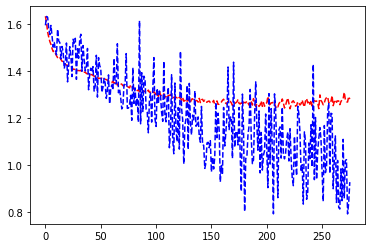

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

##lr$=5e-3$ y lr$=2e-11$

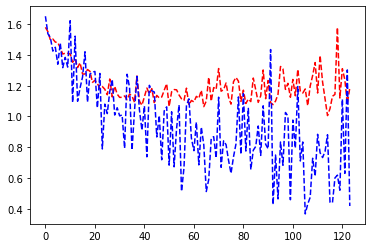

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

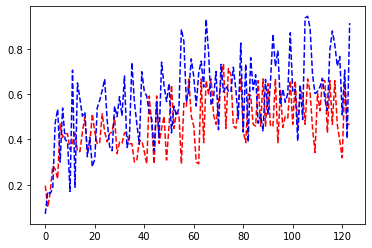

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

##lr$=1e-2$ y lr$=2e-11$

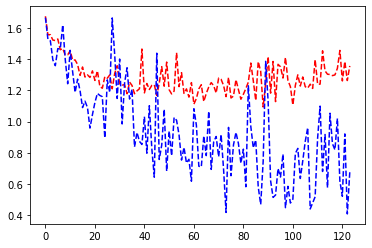

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

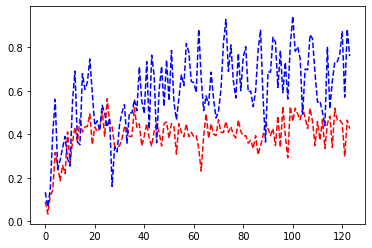

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

##lr$=1e-2$ y lr$=2e-12$

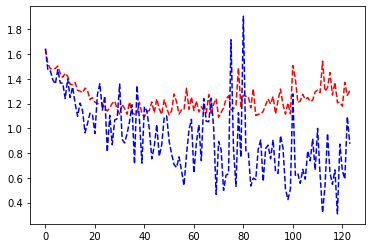

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

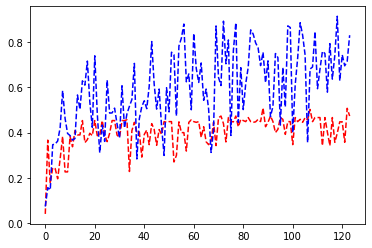

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

##lr$=1e-2$ y lr$=2e-11$

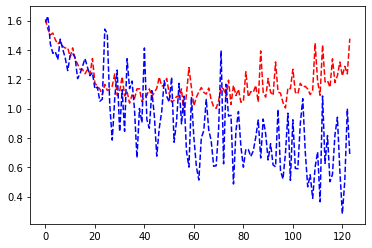

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

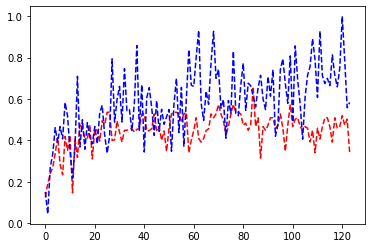

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

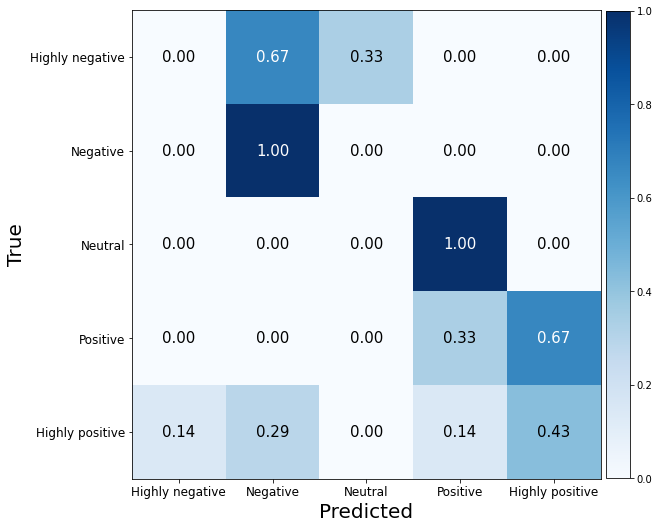

Loss:1.54, F1:0.27, Acc:0.38


In [ ]:
eval_model()

##lr$=1e-2$ y lr$=2e-10$

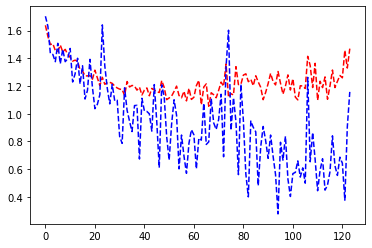

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

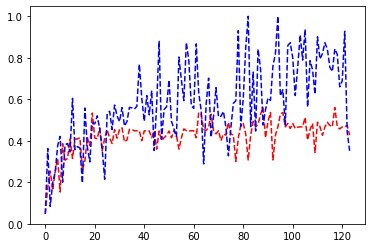

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

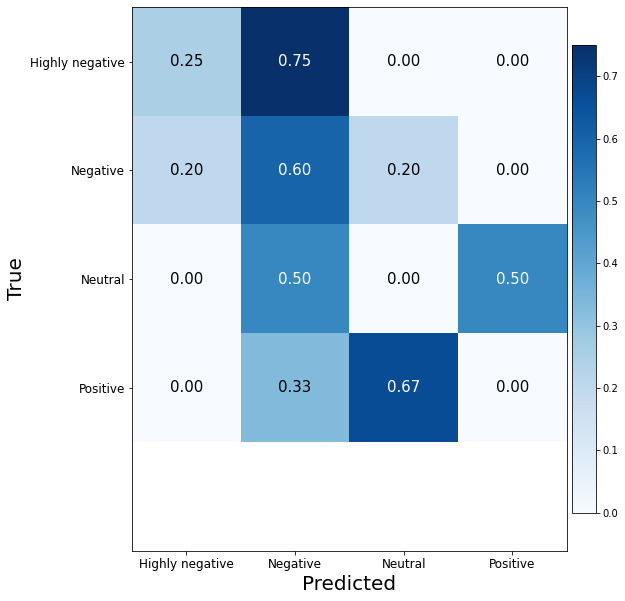

Loss:2.42, F1:0.19, Acc:0.25


In [ ]:
eval_model()

##lr$=1e-2$ y lr$=2e-9$
##Usando varios sets de validacion


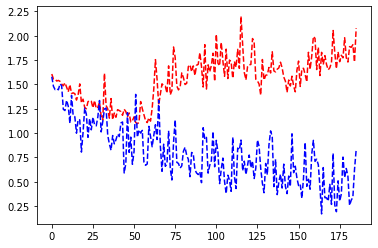

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

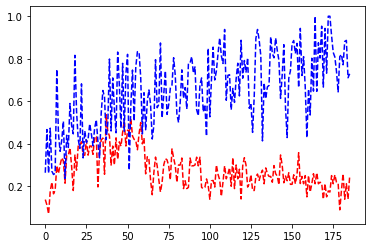

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

##lr$=1e-2$ y lr$=5e-11$

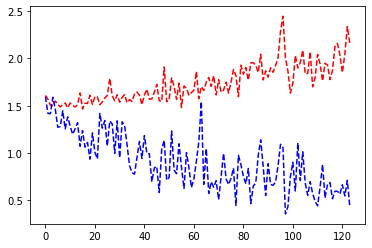

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

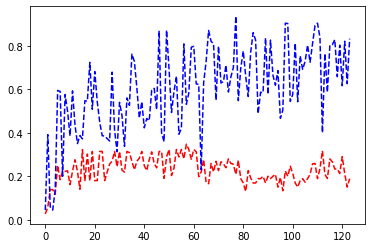

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

##lr$=1e-2$ y lr$=5e-10$

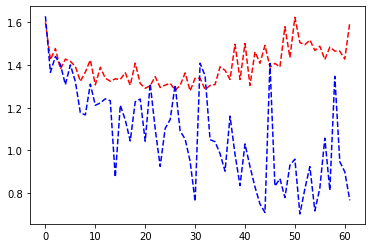

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

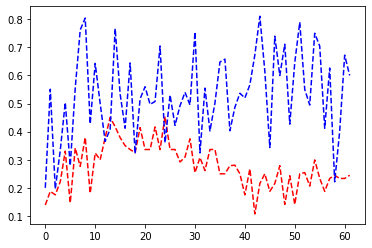

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

##lr$=1e-2$ y lr$=1e-11$

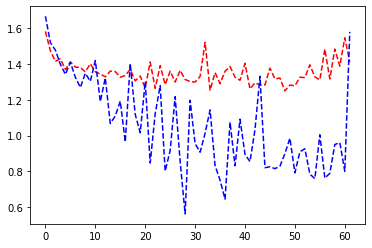

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

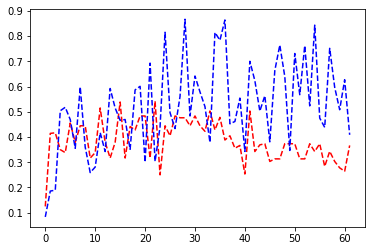

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

##lr$=1e-2$ y lr$=2e-10$

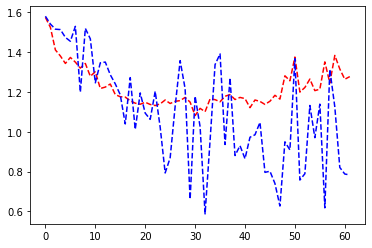

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

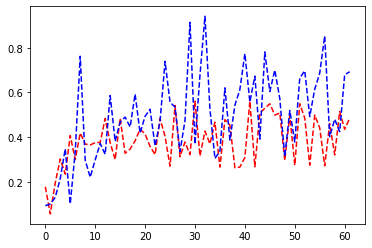

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

##lr$=1e-2$ y lr$=2e-8$

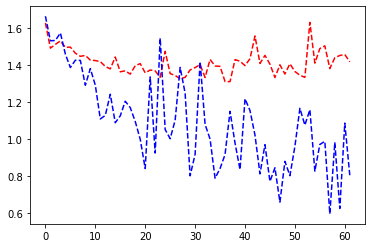

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

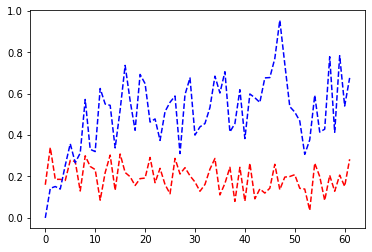

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

##lr$=1e-2$ y lr$=2e-9$

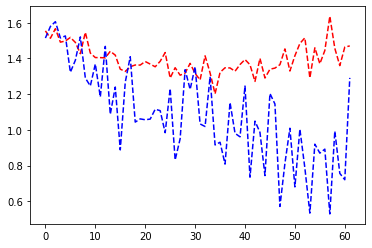

In [ ]:
plt.plot(scores['val_loss'], '--', c='r')
plt.plot(scores['train_loss'], '--', c='b')

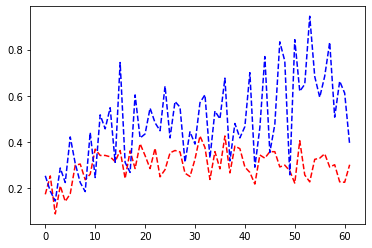

In [ ]:
plt.plot(scores['val_f1'], '--', c='r')
plt.plot(scores['train_f1'], '--', c='b')

#Pruebas sin validacion

##Prueba sobre el set de entrenamiento (sobre entrenamiento)

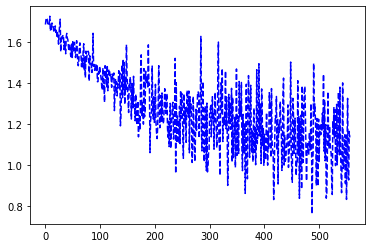

In [ ]:
plt.plot(loss_list, '--', c='b')

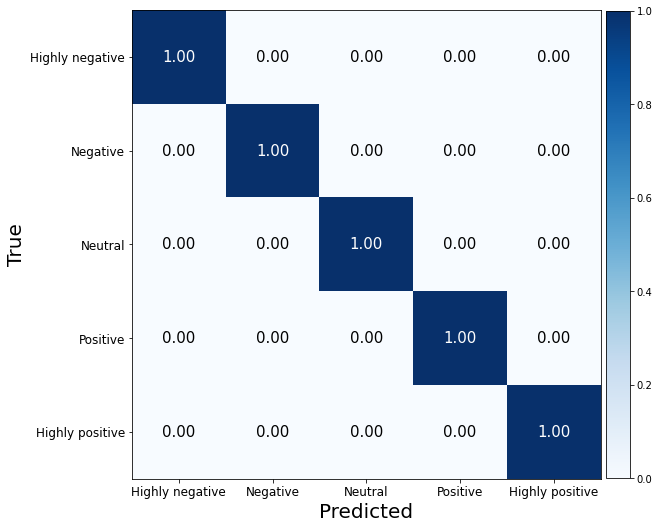

Loss:0.08, F1:1.00, Acc:1.00


In [ ]:
eval_model()

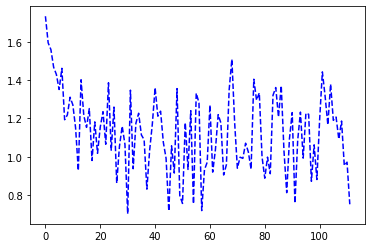

In [ ]:
plt.plot(loss_list, '--', c='b')

(1.0, 1.7)

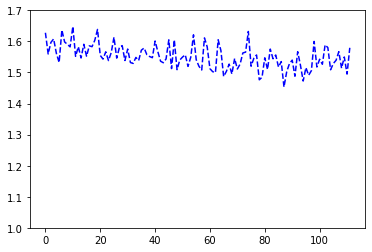

In [ ]:
plt.plot(loss_list, '--', c='b')
plt.ylim(1,1.7)

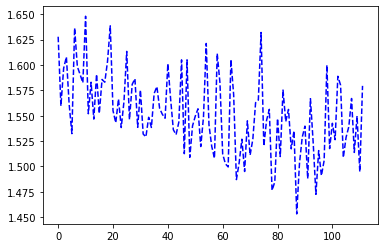

In [ ]:
plt.plot(loss_list, '--', c='b')

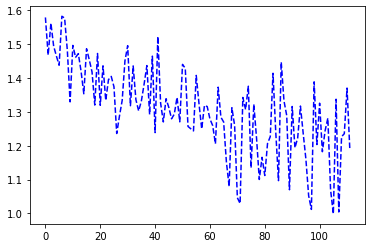

In [ ]:
plt.plot(loss_list, '--', c='b')

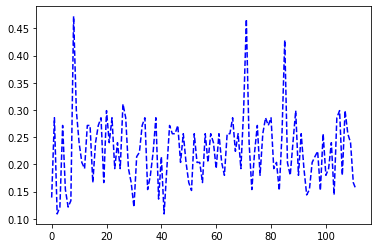

In [ ]:
plt.plot(f1_list, '--', c='b')

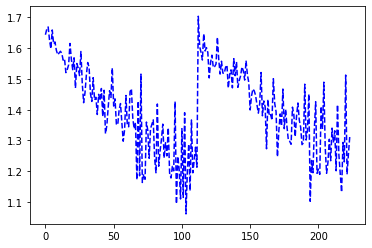

In [ ]:
plt.plot(loss_list, '--', c='b')

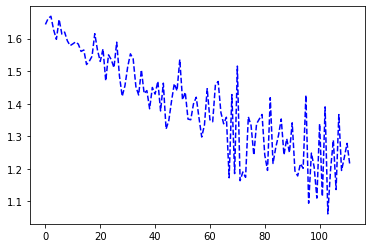

In [ ]:
plt.plot(loss_list, '--', c='b')

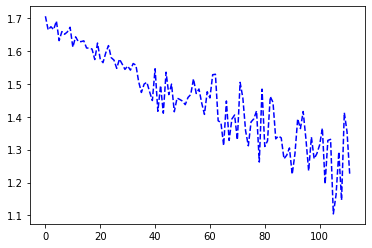

In [ ]:
plt.plot(loss_list, '--', c='b')

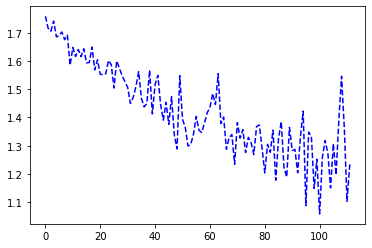

In [ ]:
plt.plot(loss_list, '--', c='b')

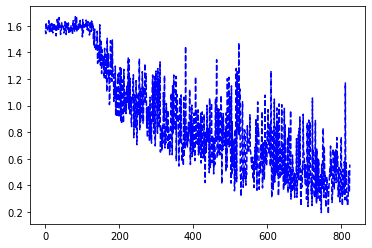

In [ ]:
plt.plot(loss_list, '--', c='b')

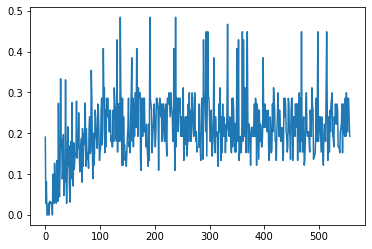

In [ ]:
plt.plot(f1_list, label='f1')

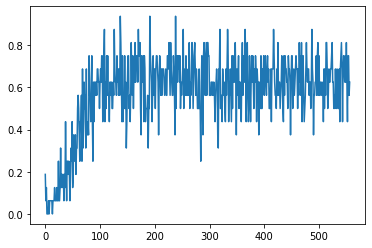

In [ ]:
plt.plot(acc_list, label='acc')

  0%|          | 0/314 [00:00<?, ?it/s]

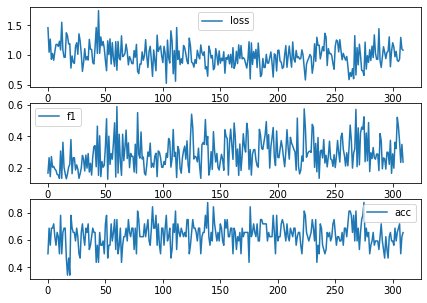

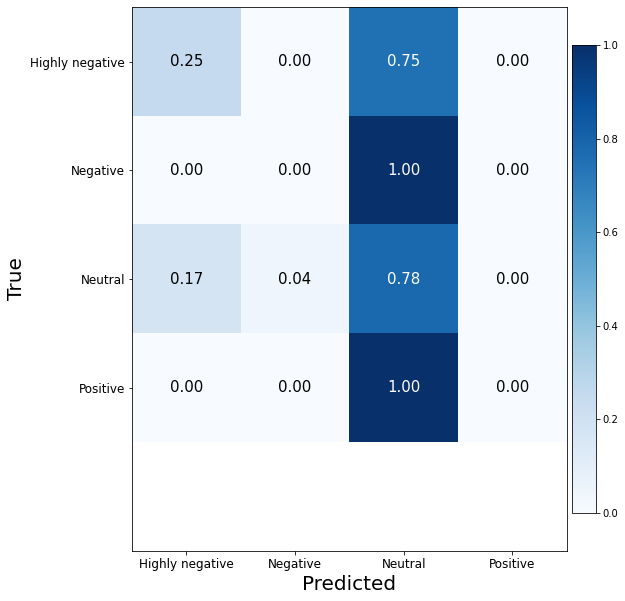

Loss:0.95, F1:0.24, Acc:0.59


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.1, WEIGHT_DECAY=0.005)

  0%|          | 0/314 [00:00<?, ?it/s]

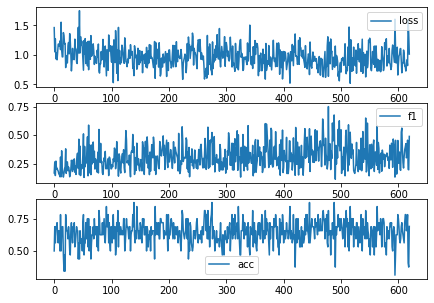

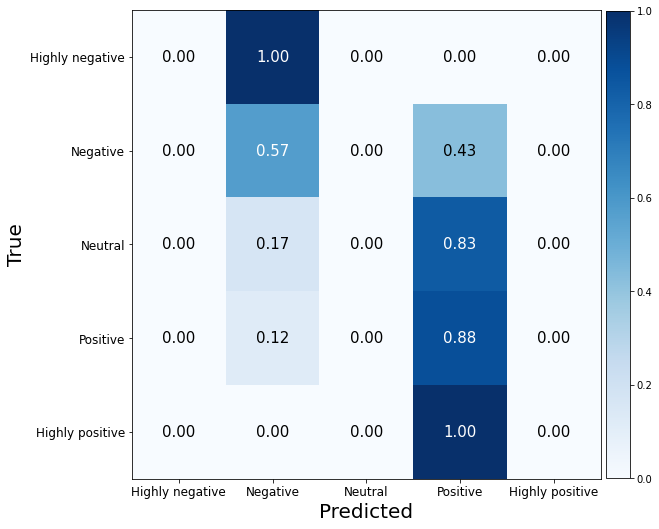

Loss:1.18, F1:0.25, Acc:0.59


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.1, WEIGHT_DECAY=0.05)

  0%|          | 0/314 [00:00<?, ?it/s]

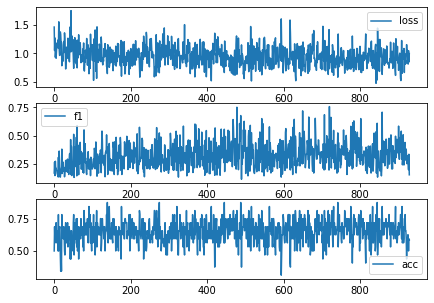

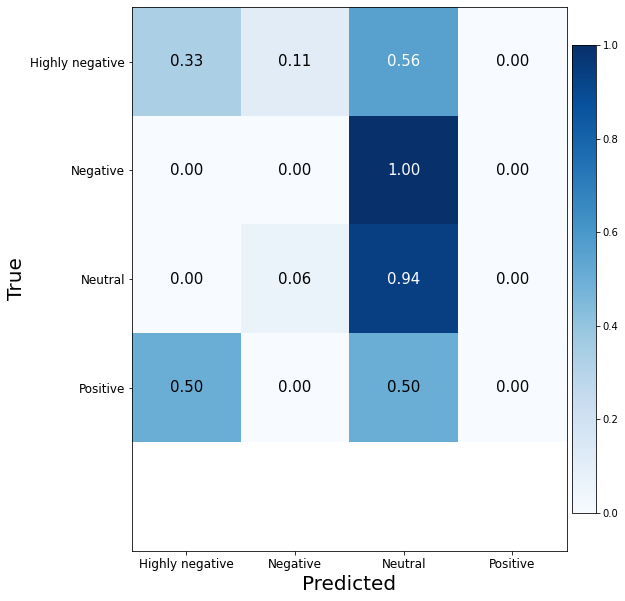

Loss:1.00, F1:0.29, Acc:0.56


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.1, WEIGHT_DECAY=0.5)

  0%|          | 0/314 [00:00<?, ?it/s]

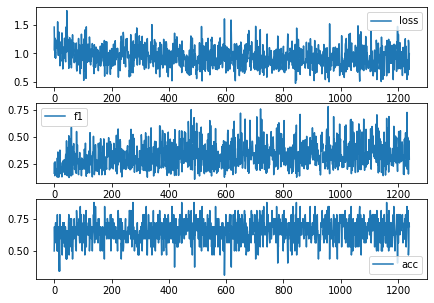

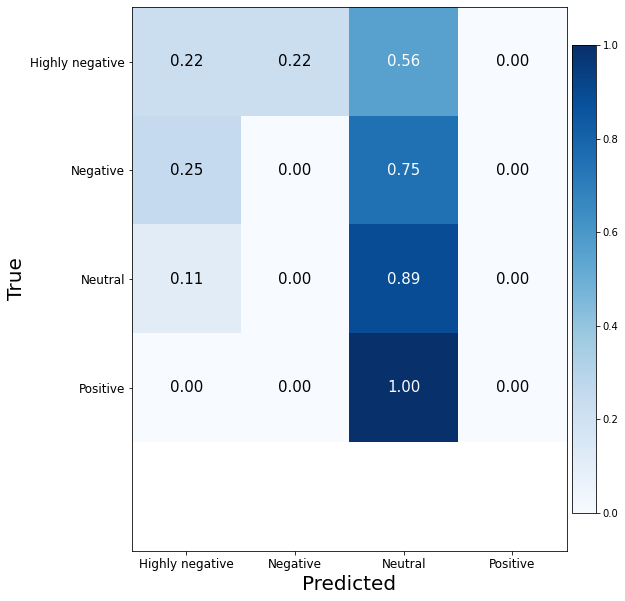

Loss:0.94, F1:0.26, Acc:0.56


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.1, WEIGHT_DECAY=1)

  0%|          | 0/314 [00:00<?, ?it/s]

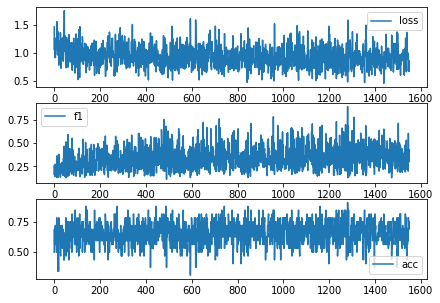

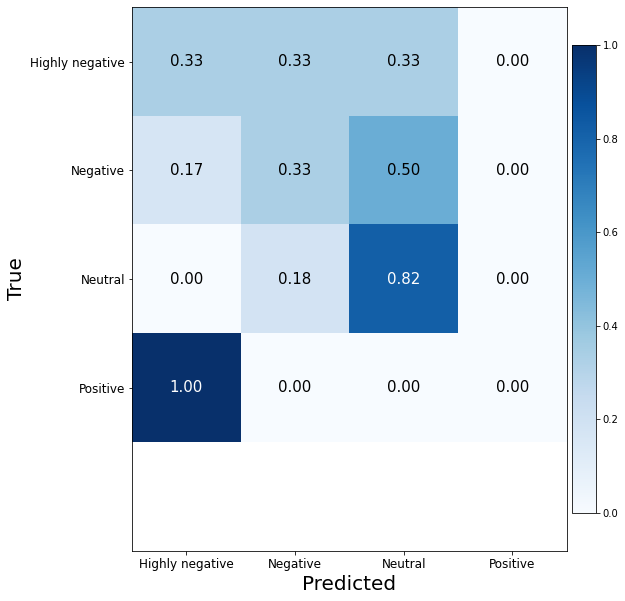

Loss:0.84, F1:0.36, Acc:0.66


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.05, WEIGHT_DECAY=0.005)

  0%|          | 0/314 [00:00<?, ?it/s]

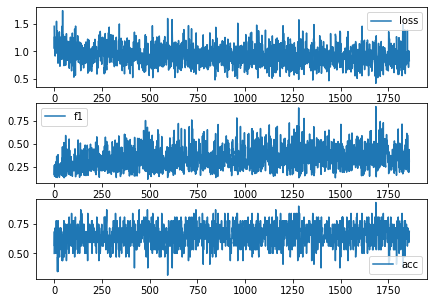

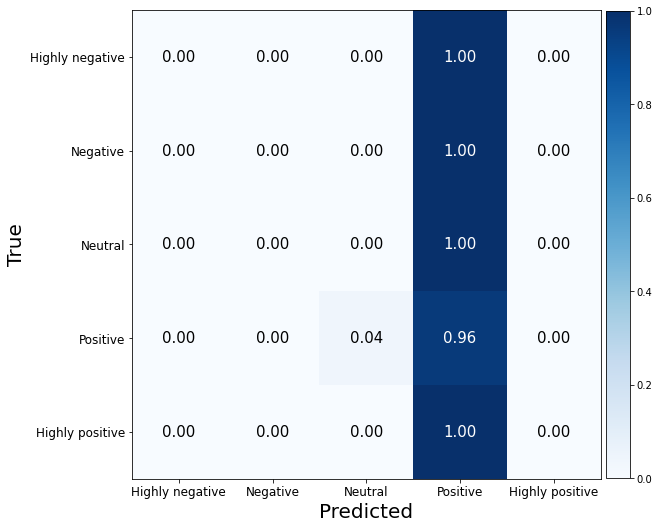

Loss:0.80, F1:0.17, Acc:0.72


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.01, WEIGHT_DECAY=0.005)

  0%|          | 0/314 [00:00<?, ?it/s]

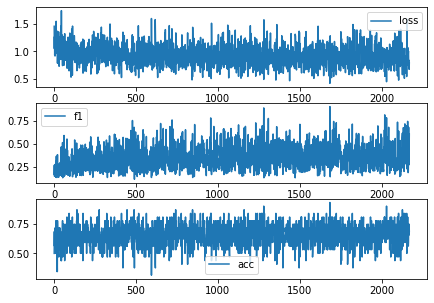

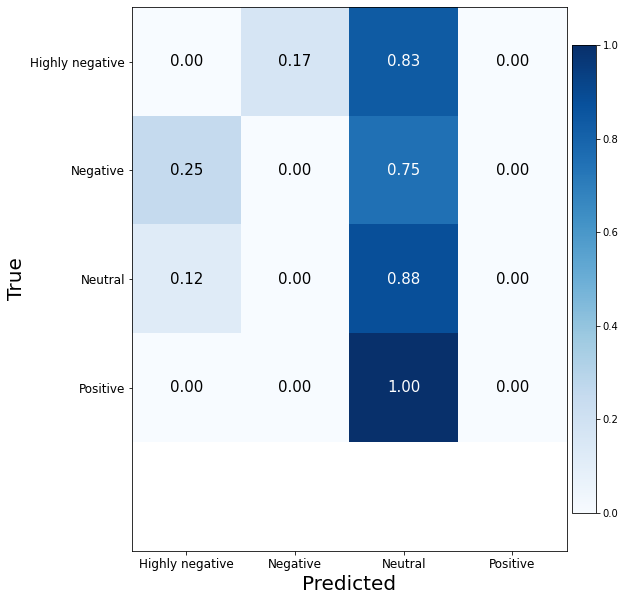

Loss:1.32, F1:0.17, Acc:0.47


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.005, WEIGHT_DECAY=0.005)

  0%|          | 0/314 [00:00<?, ?it/s]

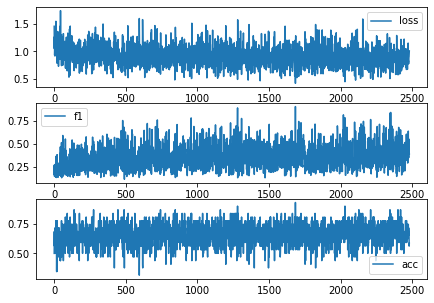

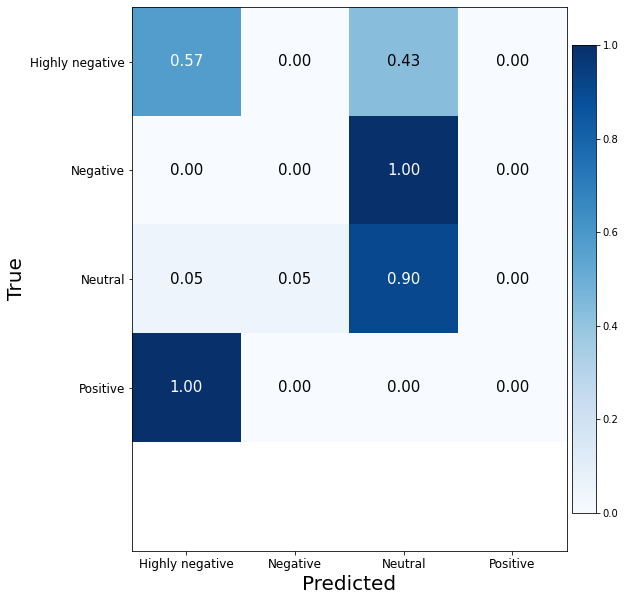

Loss:0.92, F1:0.36, Acc:0.72


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.001, WEIGHT_DECAY=0.005)

  0%|          | 0/314 [00:00<?, ?it/s]

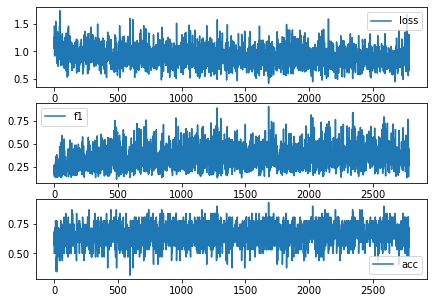

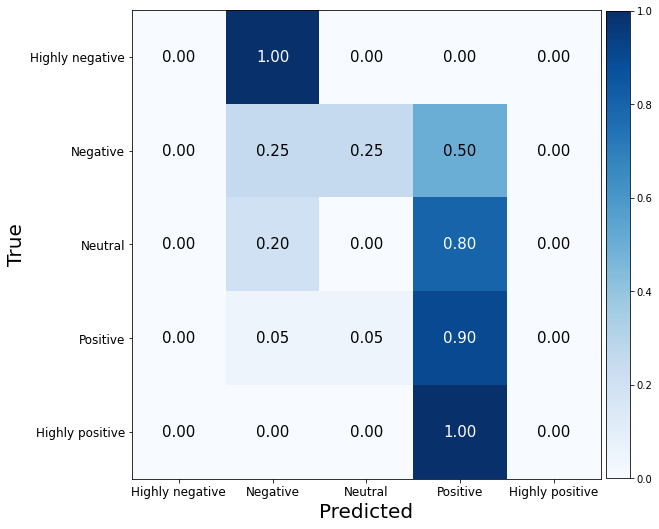

Loss:0.98, F1:0.21, Acc:0.59


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.0001, WEIGHT_DECAY=0.1)

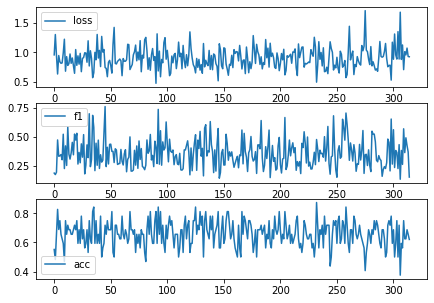

In [ ]:
fig = plt.figure(figsize=(7,5))
plt.subplot(3,1,1)
plt.plot(loss_list, label='loss')
#plt.plot(valid_loss_list, label='valid loss')
plt.legend()
plt.subplot(3,1,2)
plt.plot(f1_list, label='f1')
#plt.plot(valid_f1_list, label='valid f1')
plt.legend()
plt.subplot(3,1,3)
plt.plot(acc_list, label='acc')
#plt.plot(valid_acc_list, label='valid acc')
plt.legend()

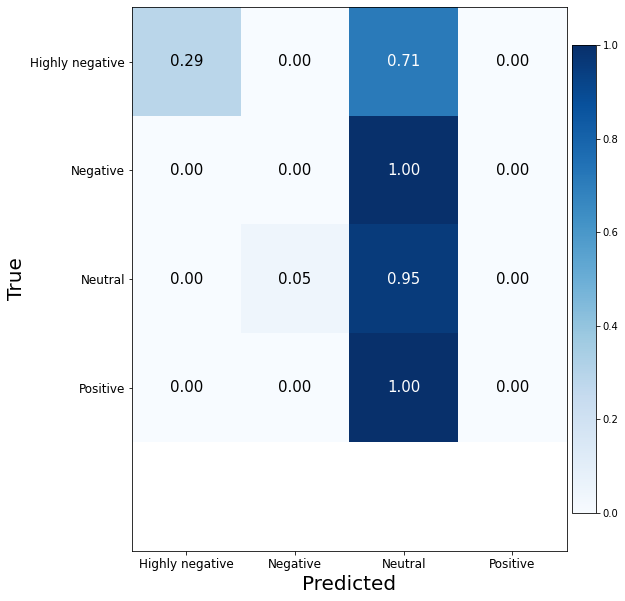

Loss:0.88, F1:0.32, Acc:0.72


In [ ]:
eval_model()

In [ ]:
train_model(EPOCHS=10,LEARNING_RATE = 0.05,WEIGHT_DECAY = 0.0001)

  0%|          | 0/850 [00:00<?, ?it/s]

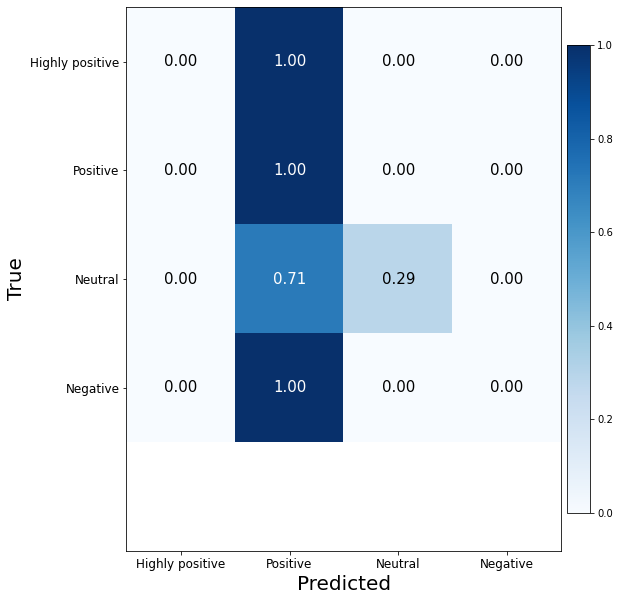

Loss:1.87, F1:0.31, Acc:0.69


In [ ]:
eval_model(classes=5)

In [ ]:
train_model(EPOCHS=5,LEARNING_RATE = 0.1,WEIGHT_DECAY = 0.0001)

  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


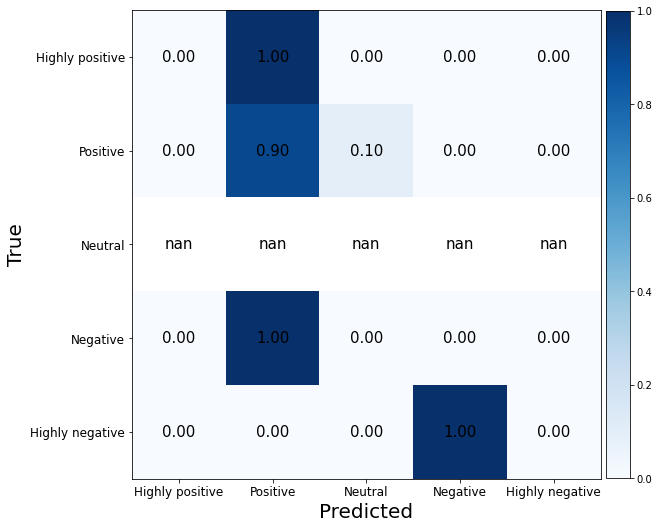

Loss:3.88, F1:0.15, Acc:0.59


In [ ]:
eval_model(classes=5)

In [ ]:
train_model(EPOCHS=5,LEARNING_RATE = 0.01,WEIGHT_DECAY = 0.001)

  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


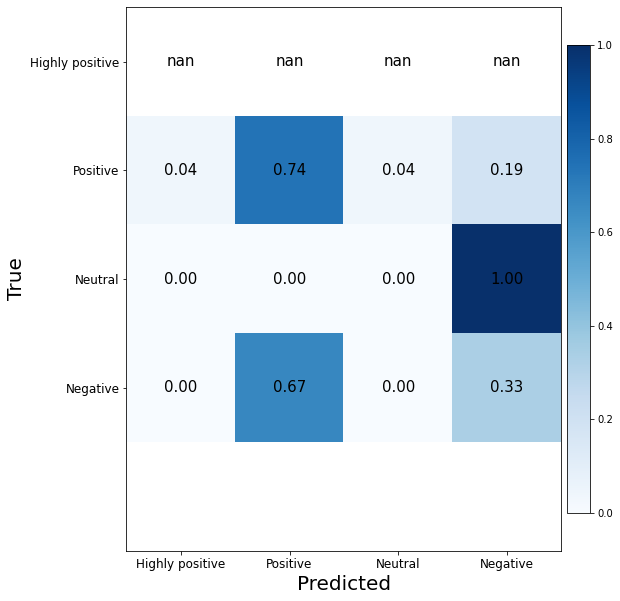

Loss:1.55, F1:0.25, Acc:0.66


In [ ]:
eval_model(classes=5)

In [ ]:
train_model(EPOCHS=5,LEARNING_RATE = 0.01,WEIGHT_DECAY = 0.005)

  0%|          | 0/425 [00:00<?, ?it/s]

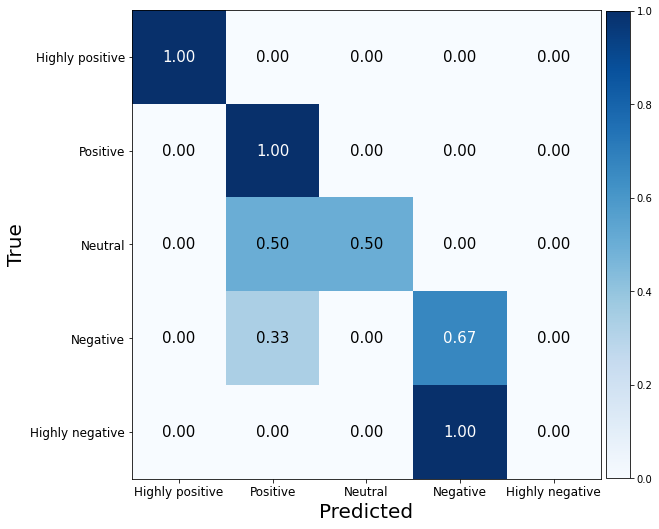

Loss:0.63, F1:0.67, Acc:0.88


In [ ]:
eval_model(classes=5)

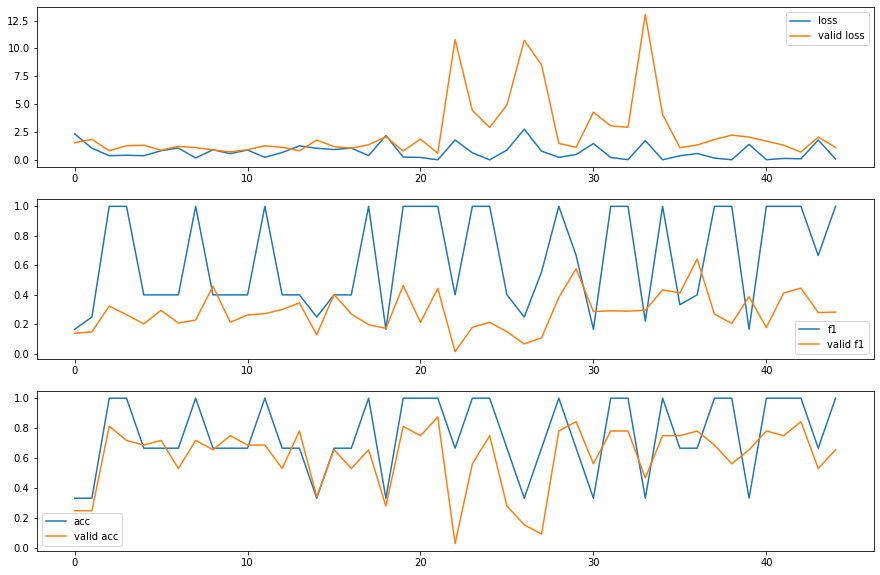

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(loss_list, label='loss')
plt.plot(valid_loss_list, label='valid loss')
plt.legend()
plt.subplot(3,1,2)
plt.plot(f1_list, label='f1')
plt.plot(valid_f1_list, label='valid f1')
plt.legend()
plt.subplot(3,1,3)
plt.plot(acc_list, label='acc')
plt.plot(valid_acc_list, label='valid acc')
plt.legend()